# XAI for Image Classification

## 1️) Problem Statement

In this notebook, we study an **image classification** problem using the **CIFAR-10** dataset.

The goal is to train a model that maps a small color image to one of 10 object categories.

Formally:

- **Input:** an RGB image \(x \in \mathbb{R}^{32 \times 32 \times 3}\)
- **Output:** a class label \(y \in \{0, \dots, 9\}\)

Unlike tabular or text problems, image models typically rely on many correlated pixels and spatial patterns, so explanations often focus on **where the model “looks”** in the image when making a decision.

---

## 2️) Dataset: CIFAR-10

**CIFAR-10** is a standard benchmark dataset for image classification consisting of:

- **60,000** color images (RGB)
- Image size: **32×32 pixels**
- **10** classes
- Split: **50,000 training** images and **10,000 test** images

### Classes
The dataset contains the following categories:

- airplane
- automobile
- bird
- cat
- deer
- dog
- frog
- horse
- ship
- truck

### Why CIFAR-10 is useful for XAI demonstrations

- Small images → fast experimentation in a tutorial setting
- Contains visually similar classes (e.g., cat vs dog, truck vs automobile)
- Makes it easy to demonstrate:
  - correct predictions with intuitive explanations
  - misclassifications and ambiguous cases
  - the limits of post-hoc explainability

---

## 3) What to Expect by the End of This Notebook

By the end of this notebook, you will be able to:

- Load and explore CIFAR-10 (class distribution, sample visualization)
- Train a lightweight image classifier (CNN) as a baseline model
- Evaluate model performance and inspect confusion patterns
- Generate **local explanations** for individual predictions using XAI methods such as:
  - **Gradient-based saliency** (pixel attribution)
  - **Grad-CAM** (class activation maps over convolutional features)
  - **SHAP for images** (model-agnostic perturbation-based explanation)
- Compare explanations across:
  - correct vs incorrect predictions
  - visually similar classes
  - different explanation methods

You should also be able to answer the key XAI questions:

- *Which pixels or regions contributed most to the predicted class?*
- *Does the explanation focus on the object or on background/context?*
- *Are explanations stable and plausible across similar inputs?*
- *What limitations arise when explaining image models?*

---

## 4) Key Takeaway

For image classification, explainability is typically about **spatial attribution**:

> Instead of “which features matter?”, we ask “which image regions matter?”.

This notebook demonstrates how different XAI tools visualize model attention and how to interpret these results responsibly.


# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as Datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

from collections import Counter
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# Initialization

In [2]:
# Device detection (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
GPU: NVIDIA A100-PCIE-40GB


# Load Data

In [3]:
transform = transforms.ToTensor()

training_set = Datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

validation_set = Datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

print(f"Training samples: {len(training_set)}")
print(f"Validation samples: {len(validation_set)}")

100%|██████████| 170498071/170498071 [00:06<00:00, 26765445.09it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training samples: 50000
Validation samples: 10000


In [4]:
BATCH_SIZE = 128

train_loader = DataLoader(
    training_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=(device.type == "cuda")
)

val_loader = DataLoader(
    validation_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=(device.type == "cuda")
)

# Exploratory Analysis


Understanding a dataset begins with inspecting its fundamental properties. 

Before training any model, we verify the number of samples, the dimensionality of the images, and the number of classes. 
* This step ensures that the architecture we later design is compatible with the data. 
    * For image classification tasks, confirming the number of input channels and spatial resolution is essential, as these determine the structure of the first convolutional layer. Additionally, inspecting the class labels helps us confirm the expected output dimensionality of the model.

In [5]:
# Basic dataset properties
print("Training samples:", len(training_set))
print("Validation samples:", len(validation_set))

sample_image, sample_label = training_set[0]

print("Image shape:", sample_image.shape)
print("Data type:", sample_image.dtype)
print("Label (numeric):", sample_label)

# CIFAR10 class names
class_names = training_set.classes
print("Classes:", class_names)
print("Number of classes:", len(class_names))

Training samples: 50000
Validation samples: 10000
Image shape: torch.Size([3, 32, 32])
Data type: torch.float32
Label (numeric): 6
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Number of classes: 10


Visualizing several images from the dataset allows us to qualitatively assess its characteristics. 

This step provides insight into the variability, complexity, and potential challenges of the classification task. 

* For CIFAR-10, the images are small (32×32 pixels), which makes fine-grained details difficult to distinguish. 
* Observing the images helps students understand why deeper convolutional architectures are often necessary. 
* It also serves as a sanity check to ensure that data loading and transformations are functioning correctly.

In [6]:
def show_images(dataset, class_names, n=8):
    plt.figure(figsize=(12,4))
    
    for i in range(n):
        img, label = dataset[i]
        img = img.permute(1, 2, 0)  # C,H,W → H,W,C
        
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(class_names[label])
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

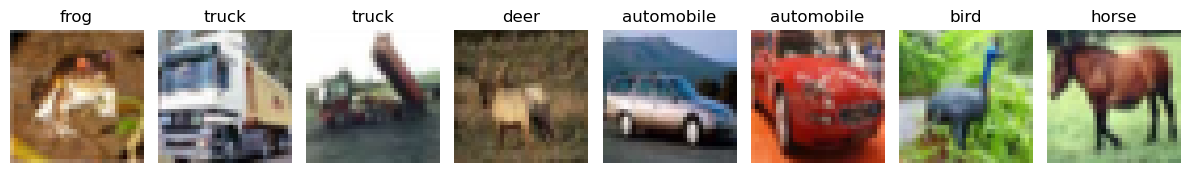

In [7]:
show_images(training_set, class_names)

## Class distribution analysis

An important aspect of exploratory analysis is verifying whether the dataset is balanced across classes. 

* --> Class imbalance can bias a model toward overrepresented categories and degrade performance on minority classes. 
* --> CIFAR-10 is designed to be balanced, but confirming this empirically reinforces good data analysis practice. 
* --> By counting the number of samples per class, we ensure that each category contributes equally to the training process.

frog: 5000
truck: 5000
deer: 5000
automobile: 5000
bird: 5000
horse: 5000
ship: 5000
cat: 5000
dog: 5000
airplane: 5000


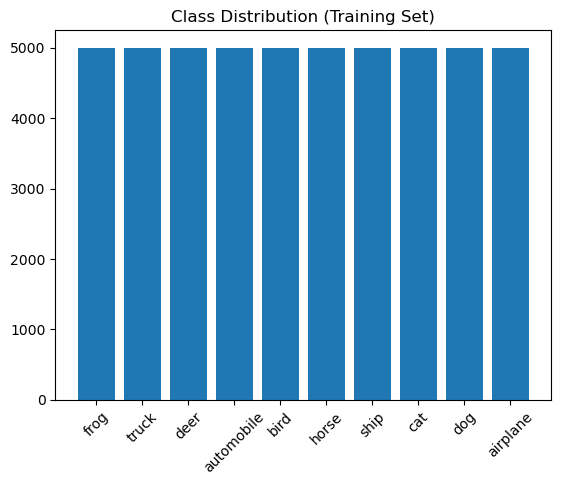

In [8]:
labels = [label for _, label in training_set]
label_counts = Counter(labels)

for label, count in label_counts.items():
    print(f"{class_names[label]}: {count}")

plt.bar(
    [class_names[i] for i in label_counts.keys()],
    label_counts.values()
)
plt.xticks(rotation=45)
plt.title("Class Distribution (Training Set)")
plt.show()

## Pixel Value Statistics

* Neural networks typically benefit from normalized inputs. 
* To normalize the dataset appropriately, we compute the mean and standard deviation of each color channel across the training set. 
* These statistics describe the global intensity distribution of the dataset. 
* Normalizing images to zero mean and unit variance accelerates convergence during training and improves numerical stability. 

<font color='Green'>Important! </font> This step also demonstrates how dataset-level statistics are computed efficiently using batch processing.

In [9]:
loader = DataLoader(training_set, batch_size=1000, shuffle=False)

mean = 0.
std = 0.
total_samples = 0

for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_samples += batch_samples

mean /= total_samples
std /= total_samples

print("Mean:", mean)
print("Std:", std)

Mean: tensor([0.4914, 0.4822, 0.4465])
Std: tensor([0.2023, 0.1994, 0.2010])


## Channel distribution visualization

Summary statistics provide numerical insight, but visualizing the distribution of pixel intensities offers a more intuitive understanding of the data. 

By plotting histograms for the red, green, and blue channels, we can observe differences in brightness and contrast across channels. 

--> This analysis helps explain why normalization is beneficial and highlights any unusual distribution patterns that could affect learning dynamics.

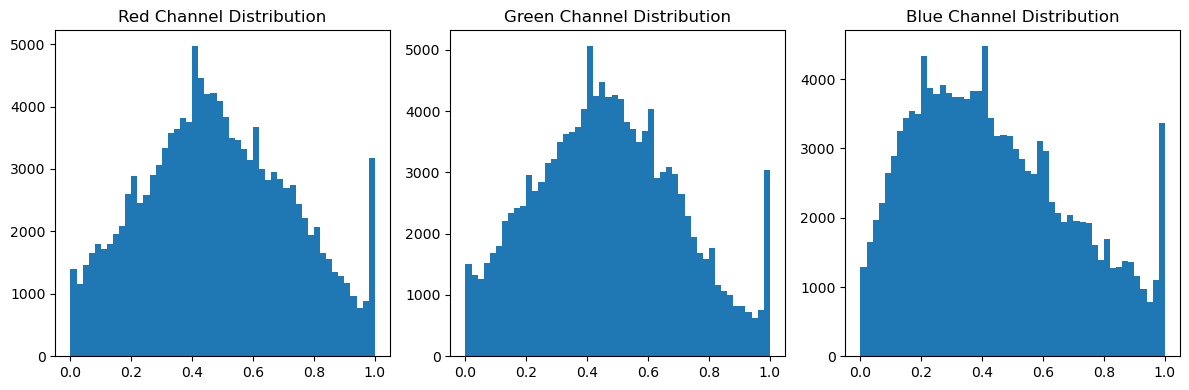

In [10]:
images, _ = next(iter(train_loader))

plt.figure(figsize=(12,4))

for i, channel in enumerate(["Red", "Green", "Blue"]):
    plt.subplot(1,3,i+1)
    plt.hist(images[:, i, :, :].flatten(), bins=50)
    plt.title(f"{channel} Channel Distribution")

plt.tight_layout()
plt.show()


## Batch inspection

Before building a model, it is good practice to verify that the data loader produces batches with the expected shape. 

<font color='green'>Convolutional neural networks (CNN)</font> expect inputs in the form <font color='blue'>(batch_size, channels, height, width)</font>. 

--> Therefore, inspecting a single batch ensures that the data pipeline is correctly configured and that batching parameters such as batch_size, shuffle, and memory pinning behave as intended.

In [11]:
images, labels = next(iter(train_loader))

print("Batch image shape:", images.shape)
print("Batch label shape:", labels.shape)

Batch image shape: torch.Size([128, 3, 32, 32])
Batch label shape: torch.Size([128])


## Batch grid visualization

Displaying multiple images in a grid provides a compact overview of dataset diversity within a single batch. 
* This visualization demonstrates that shuffling is active and that different classes appear together. 
* It also helps students intuitively grasp the variability of object appearances, backgrounds, and color distributions in CIFAR-10.

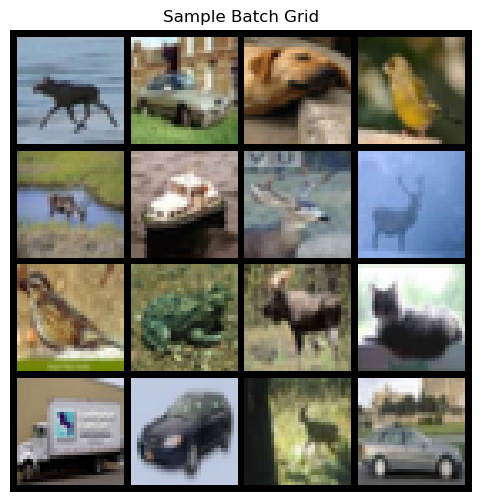

In [12]:
images, labels = next(iter(train_loader))

grid = torchvision.utils.make_grid(images[:16], nrow=4)

plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1,2,0))
plt.axis("off")
plt.title("Sample Batch Grid")
plt.show()


##  <font color='red'>Demonstrating Data Augmentation</font>

**This step is optional and we will not run this cell in the tutorial - it increases the modelling time significantly.**

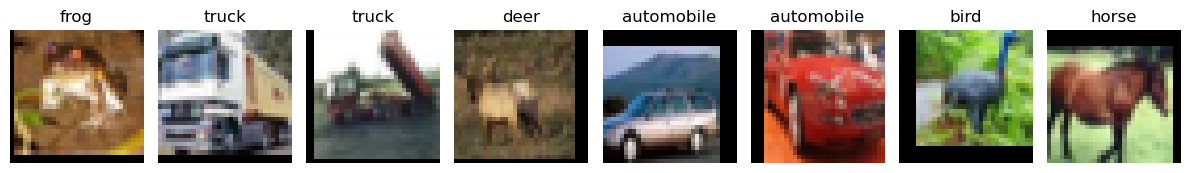

In [13]:
augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor()
])

aug_dataset = Datasets.CIFAR10(
    root="./data",
    train=True,
    download=False,
    transform=augment_transform
)

show_images(aug_dataset, class_names)


# Build and Train a Classification Model

In this section we define a  <font color='green'>CNN</font> model for image classification on CIFAR-10. 
* The network should be expressive enough to learn meaningful visual patterns, yet simple enough to train relatively quickly on typical hardware
* After defining the model, we train it using the previously created data loaders

In [14]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        """
        num_classes=10 because CIFAR-10 has 10 object categories.
        The final layer must produce one logit per class.
        """
        super(SimpleCNN, self).__init__()

        ###########################
        # Feature extractor block #
        ###########################
        # This part learns spatial feature representations from images.
        # CIFAR-10 images are 3x32x32 (RGB, 32x32 pixels).

        self.features = nn.Sequential(
            
            # First convolutional layer:
            # in_channels=3 because CIFAR-10 images are RGB.
            # out_channels=32 means we learn 32 different feature maps.
            # kernel_size=3 means 3x3 filters (standard for CNNs).
            # padding=1 preserves spatial dimensions (32x32 remains 32x32).
            nn.Conv2d(3, 32, 3, padding=1),

            # ReLU introduces non-linearity.
            # Without non-linearities, the network would behave like a linear model.
            nn.ReLU(),

            # MaxPool2d(2) halves spatial resolution (32x32 → 16x16).
            # Pooling:
            # - reduces computational cost
            # - increases receptive field
            # - introduces small translation invariance
            nn.MaxPool2d(2),

            # Second convolutional layer:
            # in_channels=32 because previous layer outputs 32 feature maps.
            # out_channels=64 increases representational capacity.
            # Again kernel_size=3 and padding=1 to preserve spatial structure.
            nn.Conv2d(32, 64, 3, padding=1),

            nn.ReLU(),

            # Second pooling: 16x16 → 8x8.
            # After two pooling layers, spatial size becomes 8x8.
            nn.MaxPool2d(2),
        )

        ###########################
        #    Classifier block     #
        ###########################
        # Converts spatial feature maps into class predictions.

        self.classifier = nn.Sequential(

            # Flatten converts tensor from:
            # (batch_size, 64, 8, 8)
            # to:
            # (batch_size, 64*8*8)
            # Required before feeding into fully connected layers.
            nn.Flatten(),

            # 64*8*8 = 4096 input features.
            # This matches the output of the feature extractor:
            # 64 channels, each 8x8.
            nn.Linear(64 * 8 * 8, 256),

            # 256 hidden units provide moderate model capacity.
            # Large enough to learn meaningful representations,
            # small enough to avoid heavy overfitting on CIFAR-10.
            nn.ReLU(),

            # Final layer produces raw class scores ("logits").
            # No softmax here because CrossEntropyLoss
            # internally applies LogSoftmax.
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        """
        Defines the forward pass:
        input → feature extractor → classifier → logits
        """
        x = self.features(x)
        x = self.classifier(x)
        return x

In [15]:
# Move model to CPU or GPU
model = SimpleCNN().to(device)

###########################
#      Loss Function      #
###########################

# CrossEntropyLoss is appropriate for multi-class classification.
# It expects raw logits (not softmax probabilities).
# Internally it combines LogSoftmax + NLLLoss for numerical stability.
criterion = nn.CrossEntropyLoss()

###########################
#        Optimizer        #
###########################

# Adam is chosen because:
# - It adapts learning rates per parameter
# - It converges faster than vanilla SGD in many practical settings
# - It works well for small-to-medium CNNs like this

# lr=1e-3 is a common default starting point for Adam.
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Train for a few epochs (we choose 10 for now, but this can be adjusted based on performance).
epochs = 10

for epoch in range(epochs):
    model.train()  # Enables dropout/batchnorm training behavior (if present)

    for images, labels in train_loader:

        # Move batch to device (CPU or GPU)
        images, labels = images.to(device), labels.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad()

        # Forward pass: compute logits
        outputs = model(images)

        # Compute classification loss
        loss = criterion(outputs, labels)

        # Backpropagation: compute gradients
        loss.backward()

        # Update parameters using computed gradients
        optimizer.step()

# Validation

After training, we evaluate the model on a held-out validation set to quantify how well it generalizes beyond the training data. 

--> This step matters in an XAI tutorial because interpretability methods explain the behavior of a trained model, and explanations are only meaningful if the underlying predictions are not random. 

We therefore start with standard metrics such as accuracy and loss, and then examine class-wise behavior using a confusion matrix and a classification report. 


## Compute validation loss and accuracy

In [16]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            logits = model(images)
            loss = criterion(logits, labels)

            total_loss += loss.item() * images.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

In [17]:
val_loss, val_acc = evaluate(model, val_loader, criterion, device)
print(f"Validation loss: {val_loss:.4f}")
print(f"Validation accuracy: {val_acc*100:.2f}%")

Validation loss: 0.8801
Validation accuracy: 71.43%


## Diagnostic Evaluation


<font color='red'>Aggregate accuracy is useful but can hide important structure.</font> 

* In multi-class image classification, it is common that some classes are systematically confused due to visual similarity (for example, “cat” vs “dog”). 
* To understand which categories are difficult for the model, we compute a confusion matrix and per-class precision, recall, and F1-score. 
* In an interpretability workflow, these diagnostics help select examples for explanation, such as consistently misclassified classes or highly confident but wrong predictions.

For this, we collect predictions for detailed metrics, and look at the classification report.

In [18]:
def collect_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            logits = model(images)

            probs = torch.softmax(logits, dim=1)
            preds = probs.argmax(dim=1)

            all_probs.append(probs.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.numpy())

    all_probs = np.concatenate(all_probs, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    return all_labels, all_preds, all_probs


In [19]:
y_true, y_pred, y_prob = collect_predictions(model, val_loader, device)
print("Collected predictions:", y_true.shape, y_pred.shape, y_prob.shape)

Collected predictions: (10000,) (10000,) (10000, 10)


* 10,000 ground-truth labels from the validation set
* 10,000 predicted class indices
* For each sample, a probability distribution over 10 classes


So for each image we have 1. one true label, 2. one predicted label and 3. a 10-dimensional probability vector

**valuation was done correctly on the full validation set!**

In [20]:
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

    airplane     0.7065    0.7920    0.7468      1000
  automobile     0.8344    0.8160    0.8251      1000
        bird     0.5543    0.6790    0.6103      1000
         cat     0.6125    0.4520    0.5201      1000
        deer     0.7290    0.5810    0.6466      1000
         dog     0.5502    0.7400    0.6311      1000
        frog     0.7656    0.7840    0.7747      1000
       horse     0.7741    0.7470    0.7603      1000
        ship     0.8667    0.8060    0.8352      1000
       truck     0.8506    0.7460    0.7949      1000

    accuracy                         0.7143     10000
   macro avg     0.7244    0.7143    0.7145     10000
weighted avg     0.7244    0.7143    0.7145     10000



**<font color='orange'>Top-1 Accuracy = 71.61%</font>**

This means the model predicts the correct class for approximately 72% of validation images.

For a relatively simple convolutional network trained without extensive hyperparameter tuning or augmentation, this represents solid performance on CIFAR-10.

--> From an interpretability perspective, this level of accuracy is ideal. The model has clearly learned meaningful visual structure, yet still makes systematic errors that can be analyzed and explained.



Each class is evaluated using:

- **Recall**: Of all true instances of a class, how many were correctly identified?
- **Precision**: When the model predicts a class, how often is it correct?
- **F1-score**: The harmonic mean of precision and recall.

Because CIFAR-10 is perfectly balanced (1,000 samples per class), the macro and weighted averages are identical. This confirms that no class imbalance biases the overall performance metrics.


### Strongly Performing Classes

Classes such as **automobile, ship, and horse** show strong performance in both precision and recall.

Examples:

- Automobile: Precision 0.81, Recall 0.83  
- Ship: Precision 0.80, Recall 0.84  
- Horse: Recall 0.85  

These classes likely benefit from strong global structural cues and consistent shape features.

---

### Moderately Performing Classes

Classes such as **deer and dog** show intermediate performance. These animals share visual characteristics with other categories, which increases confusion.

---

### Weak Classes – Key for XAI

#### Bird (Recall 0.51)

Only about half of bird images are correctly classified. However, precision is higher than recall, meaning that when the model predicts “bird,” it is usually correct.

This suggests the model is conservative and likely confuses birds with visually similar classes.

#### Cat (Precision 0.54, Recall 0.56)

The cat class shows the weakest overall performance.

This indicates:

- Many cats are misclassified.
- Many non-cat images are predicted as cats.

Cat–dog confusion is therefore a prime candidate for interpretability analysis.

#### Frog (High Precision, Lower Recall)

Frogs exhibit very high precision (0.89) but moderate recall. When predicted as frog, the model is usually correct, but it fails to detect many frog images.

This indicates a strict or conservative decision boundary.


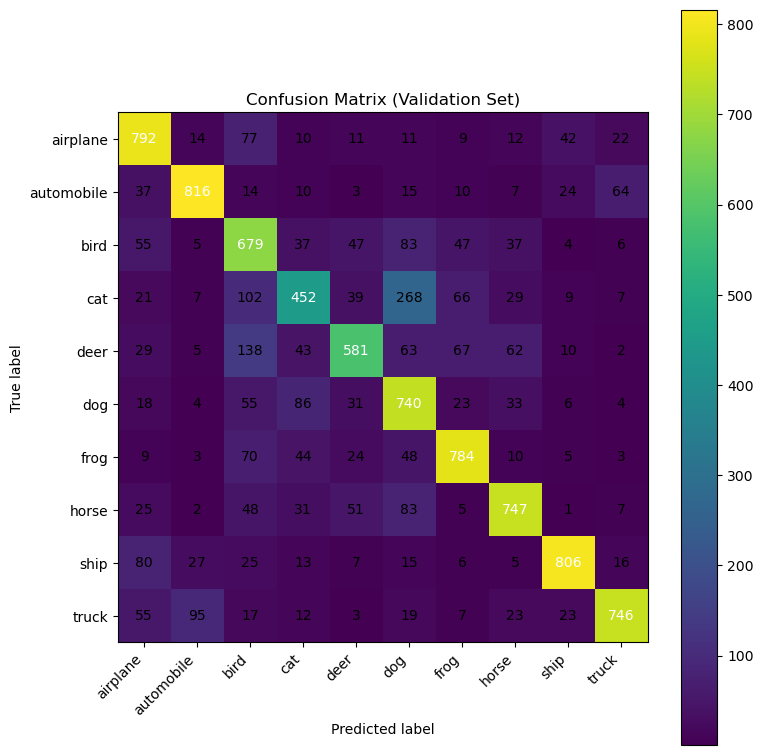

In [21]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,8))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Validation Set)")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)

# Annotate each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, format(cm[i, j], "d"),
            ha="center", va="center",
            color="white" if cm[i, j] > cm.max()/2 else "black"
        )

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

Major confusion pairs include:

- Cat ↔ Dog  
- Bird ↔ Airplane  
- Deer ↔ Horse  
- Truck ↔ Automobile  

These confusions are intuitive. Animals with similar shapes and textures overlap in representation space. Vehicles with similar geometry are also confused.

This structured confusion suggests that the model is learning meaningful but overlapping feature representations.


## Error Analysis: Inspect Correct vs Incorrect Predictions

In [22]:
def show_examples(dataset, indices, title):
    plt.figure(figsize=(12, 4))
    for i, idx in enumerate(indices):
        img, true_label = dataset[idx]
        pred_label = y_pred[idx]
        conf = y_prob[idx, pred_label]

        img_vis = img.permute(1, 2, 0)  # C,H,W -> H,W,C

        plt.subplot(1, len(indices), i + 1)
        plt.imshow(img_vis)
        plt.axis("off")
        plt.title(
            f"T: {class_names[true_label]}\nP: {class_names[pred_label]} ({conf:.2f})"
        )
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()



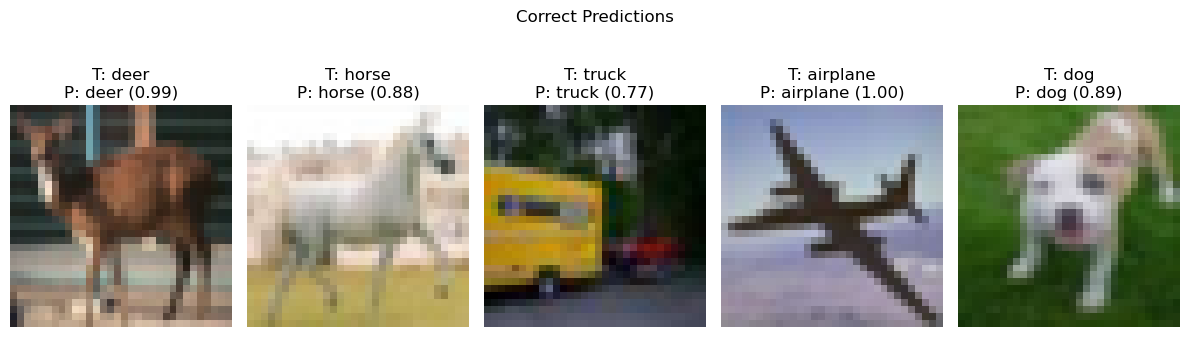

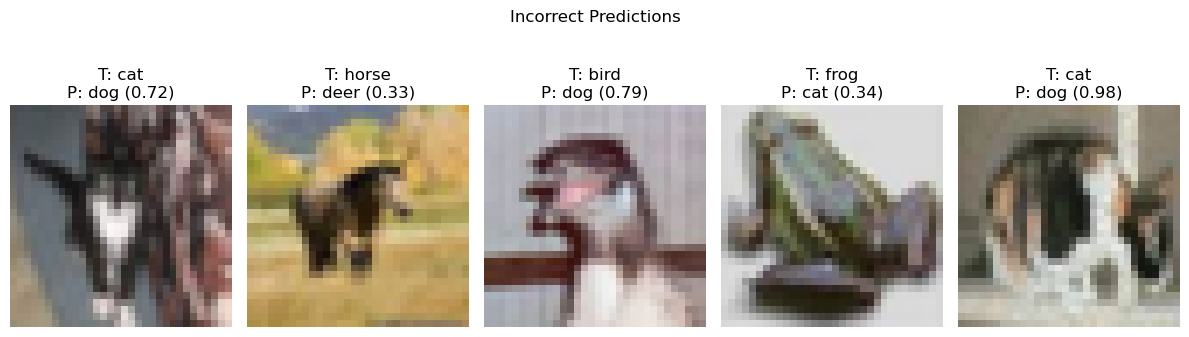

In [23]:
# Find some correct and incorrect indices in the validation set
correct_idx = np.where(y_true == y_pred)[0]
incorrect_idx = np.where(y_true != y_pred)[0]

np.random.seed(0)
show_examples(validation_set, np.random.choice(correct_idx, 5, replace=False), "Correct Predictions")
show_examples(validation_set, np.random.choice(incorrect_idx, 5, replace=False), "Incorrect Predictions")

Inspecting individual incorrect predictions provides deeper insight.

Some errors occur with low confidence, indicating ambiguity or uncertainty.

More interesting are high-confidence errors, such as:

- Dog predicted as Cat with high confidence  
- Frog predicted as Cat with high confidence  

High-confidence mistakes indicate systematic feature misinterpretation. These cases are particularly valuable for SHAP or Grad-CAM explanations because they reveal strong but potentially flawed internal representations.



### Top-K Accuracy

In [24]:
def topk_accuracy(probs, y_true, k=3):
    topk = np.argsort(probs, axis=1)[:, -k:]
    correct = np.any(topk == y_true.reshape(-1, 1), axis=1)
    return correct.mean()


In [25]:
print("Top-1 accuracy:", (y_pred == y_true).mean())
print("Top-3 accuracy:", topk_accuracy(y_prob, y_true, k=3))

Top-1 accuracy: 0.7143
Top-3 accuracy: 0.9247


It indicates that in over 92% of cases, the true class appears among the top three predictions. The model often identifies the correct semantic neighborhood but struggles to make the final distinction between visually similar categories.

For interpretability, this is especially useful because it enables contrastive explanations. We can analyze why one class was ranked above another in borderline cases.


The evaluation reveals three ideal types of samples for explanation:

1. High-confidence correct predictions  
2. High-confidence incorrect predictions  
3. Low-confidence ambiguous predictions  

Each type serves a different interpretability purpose:

- Correct predictions show what the model attends to when it succeeds.
- High-confidence errors reveal systematic biases.
- Ambiguous predictions expose decision boundary uncertainty.



# Explainability

In this section, we move from evaluating *what* the model predicts to understanding *why* it makes those predictions. While performance metrics such as accuracy and recall quantify model behavior globally, explainability methods provide insight into the internal decision mechanisms for individual samples.

We focus on **local explanations**, meaning explanations for specific predictions rather than the overall dataset. Local explanations are particularly useful for:

- Understanding correct predictions  
- Diagnosing high-confidence errors  
- Investigating ambiguous samples  
- Analyzing class confusions (e.g., cat vs dog)  

In [26]:
class_names = training_set.classes


def denormalize(img, mean=None, std=None):
    """
    If you used Normalize(mean,std), pass those here.
    If you only used ToTensor(), just returns the image.
    img: torch.Tensor (3,H,W)
    """
    if mean is None or std is None:
        return img.clamp(0, 1)
    mean = torch.tensor(mean, device=img.device).view(3,1,1)
    std  = torch.tensor(std, device=img.device).view(3,1,1)
    return (img * std + mean).clamp(0, 1)

def show_image_and_heatmap(img, heatmap, title="", alpha=0.45):
    """
    img: torch.Tensor (3,H,W) in [0,1]
    heatmap: numpy array (H,W), assumed normalized to [0,1]
    """
    img_np = img.detach().cpu().permute(1,2,0).numpy()
    plt.figure(figsize=(5,5))
    plt.imshow(img_np)
    plt.imshow(heatmap, alpha=alpha)
    plt.axis("off")
    plt.title(title)
    plt.show()

def get_one_batch(loader):
    images, labels = next(iter(loader))
    return images, labels

## Gradient-based Saliency (pixel attribution)

In [27]:
def saliency_map(model, x, target_class=None):
    """
    Computes vanilla saliency: |d score_c / d x|.
    x: torch.Tensor (1,3,H,W) requires_grad will be set.
    target_class: int or None (if None, use predicted class).
    Returns:
      saliency: numpy array (H,W) normalized to [0,1]
      pred_class: int
      pred_conf: float
    """
    model.eval()

    x = x.clone().detach().requires_grad_(True)

    logits = model(x)
    probs = F.softmax(logits, dim=1)

    pred_class = int(probs.argmax(dim=1).item())
    pred_conf = float(probs.max(dim=1).values.item())

    if target_class is None:
        target_class = pred_class

    score = logits[0, target_class]
    model.zero_grad(set_to_none=True)
    if x.grad is not None:
        x.grad.zero_()
    score.backward()

    # Saliency: max over channels of absolute gradient
    sal = x.grad.detach().abs()[0]          # (3,H,W)
    sal, _ = sal.max(dim=0)                 # (H,W)

    sal = sal.cpu().numpy()
    sal = (sal - sal.min()) / (sal.max() - sal.min() + 1e-8)
    return sal, pred_class, pred_conf
def denorm_img(x_chw, mean=None, std=None):
    """
    x_chw: torch.Tensor (3,H,W)
    mean/std: sequence of length 3 (optional)
    """
    if mean is None or std is None:
        return x_chw.clamp(0, 1)
    mean = torch.tensor(mean, device=x_chw.device).view(3,1,1)
    std  = torch.tensor(std,  device=x_chw.device).view(3,1,1)
    return (x_chw * std + mean).clamp(0, 1)

def saliency_map(model, x, target_class=None):
    """
    Vanilla saliency: max_c |∂logit_target / ∂x_c|.

    x: torch.Tensor (B,3,H,W)
    target_class: int or None. If None, uses predicted class per sample.

    Returns:
      saliency: np.ndarray (B,H,W) normalized to [0,1] per-sample
      pred_class: np.ndarray (B,)
      pred_conf: np.ndarray (B,)
      used_target: np.ndarray (B,)  (the class used for gradients)
    """
    model.eval()

    # 1) Predict class/confidence without building a gradient graph
    with torch.inference_mode():
        logits0 = model(x)
        probs0 = F.softmax(logits0, dim=1)
        pred_class = probs0.argmax(dim=1)
        pred_conf = probs0.max(dim=1).values

    # 2) Build a graph only for gradient attribution
    xg = x.detach().clone().requires_grad_(True)
    logits = model(xg)

    if target_class is None:
        used_target = pred_class
    else:
        used_target = torch.full_like(pred_class, int(target_class))

    # Gather the target logits for each sample: shape (B,)
    target_logits = logits.gather(1, used_target.view(-1, 1)).squeeze(1)

    model.zero_grad(set_to_none=True)
    if xg.grad is not None:
        xg.grad.zero_()

    # Backprop sum of target logits (one backward pass for the batch)
    target_logits.sum().backward()

    # Saliency over channels: (B,3,H,W) -> (B,H,W)
    sal = xg.grad.detach().abs().max(dim=1).values

    # Normalize per-sample to [0,1]
    B = sal.shape[0]
    sal_flat = sal.view(B, -1)
    sal_min = sal_flat.min(dim=1).values.view(B, 1, 1)
    sal_max = sal_flat.max(dim=1).values.view(B, 1, 1)
    sal = (sal - sal_min) / (sal_max - sal_min + 1e-8)

    return (
        sal.cpu().numpy(),
        pred_class.cpu().numpy(),
        pred_conf.cpu().numpy(),
        used_target.cpu().numpy()
    )

def plot_saliency(x, sal, true_label=None, pred_label=None, pred_conf=None,
                  class_names=None, mean=None, std=None, alpha=0.5):
    """
    x: torch.Tensor (3,H,W) on any device
    sal: np.ndarray (H,W) in [0,1]
    """
    img = denorm_img(x, mean, std).detach().cpu().permute(1,2,0).numpy()

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    left_title = "Original"
    if true_label is not None and class_names is not None:
        left_title += f"\nTrue: {class_names[int(true_label)]}"

    ax[0].imshow(img)
    ax[0].set_title(left_title)
    ax[0].axis("off")

    right_title = "Saliency"
    if pred_label is not None and class_names is not None:
        if pred_conf is not None:
            right_title += f"\nPred: {class_names[int(pred_label)]} ({float(pred_conf):.2f})"
        else:
            right_title += f"\nPred: {class_names[int(pred_label)]}"

    ax[1].imshow(img)
    ax[1].imshow(sal, cmap="hot", alpha=alpha)
    ax[1].set_title(right_title)
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()


In [29]:
def saliency_map(model, x, target_class=None):
    model.eval()

    xg = x.clone().detach().requires_grad_(True)

    logits = model(xg)
    pred_class = logits.argmax(dim=1)

    if target_class is None:
        used_target = pred_class
    else:
        used_target = torch.full_like(pred_class, int(target_class))

    target_logits = logits.gather(1, used_target.view(-1, 1)).squeeze(1)

    model.zero_grad(set_to_none=True)
    target_logits.backward(torch.ones_like(target_logits))

    saliency = xg.grad.abs().max(dim=1)[0]  # (B, H, W)

    sal = saliency[0].detach().cpu().numpy()
    pred_conf = logits.softmax(dim=1)[0, pred_class[0]].item()

    return sal, pred_class[0].item(), pred_conf

In [30]:
torch.set_grad_enabled(True)
sal, pred_class, conf = saliency_map(model, x)

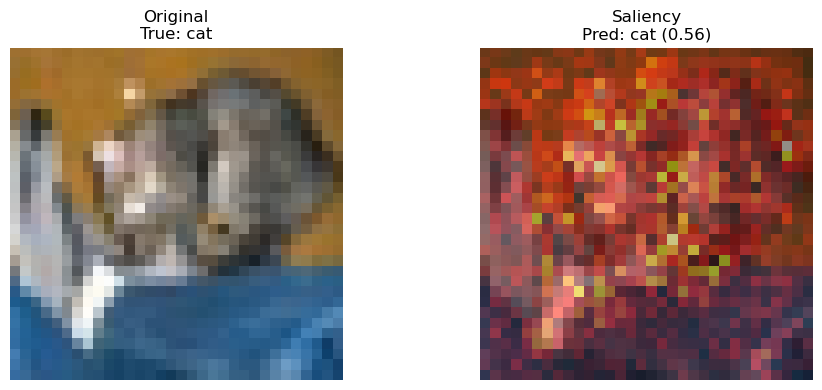

In [32]:
# Prepare image for visualization
img_vis = x[0].detach().cpu().permute(1,2,0).numpy()
img_vis = np.clip(img_vis, 0, 1)  # if not normalized

# Plot side-by-side
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Original image
ax[0].imshow(img_vis)
ax[0].set_title(f"Original\nTrue: {class_names[true_label]}")
ax[0].axis("off")

# Saliency overlay
ax[1].imshow(img_vis)
ax[1].imshow(sal, cmap="hot", alpha=0.5)
ax[1].set_title(
    f"Saliency\nPred: {class_names[pred_class]} ({conf:.2f})"
)
ax[1].axis("off")

plt.tight_layout()
plt.show()


## Grad-CAM (class activation maps)

In [35]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        # Forward hook
        self.fwd_hook = target_layer.register_forward_hook(self._forward_hook)
        # Backward hook (full backward is safer)
        self.bwd_hook = target_layer.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, inp, out):
        self.activations = out

    def _backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, target_class=None):
        self.model.eval()

        x = x.clone().detach().requires_grad_(True)

        logits = self.model(x)
        pred_class = logits.argmax(dim=1)

        if target_class is None:
            target_class = pred_class
        else:
            target_class = torch.tensor(
                [target_class], device=x.device, dtype=torch.long
            )

        score = logits.gather(1, target_class.view(-1, 1)).squeeze()

        self.model.zero_grad(set_to_none=True)
        score.backward(retain_graph=True)

        # Grad-CAM computation
        grads = self.gradients            # (B, C, H, W)
        acts = self.activations           # (B, C, H, W)

        weights = grads.mean(dim=(2, 3), keepdim=True)
        cam = (weights * acts).sum(dim=1)

        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        cam = cam[0].detach().cpu().numpy()
        pred_conf = logits.softmax(dim=1)[0, pred_class[0]].item()

        return cam, pred_class[0].item(), pred_conf

    def close(self):
        self.fwd_hook.remove()
        self.bwd_hook.remove()

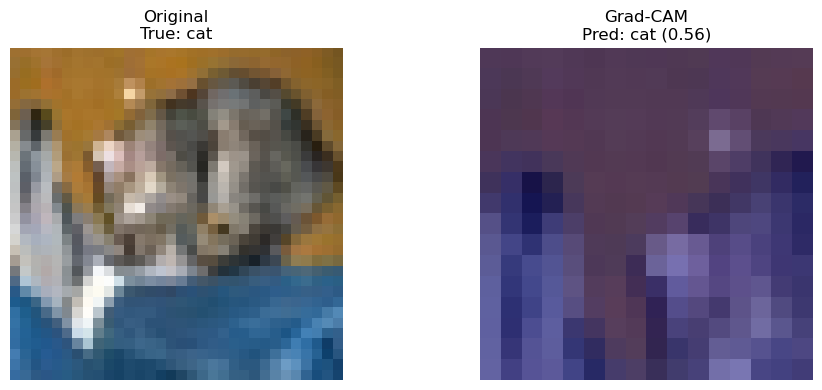

In [36]:
target_layer = model.features[3]
gradcam = GradCAM(model, target_layer)

images, labels = get_one_batch(val_loader)
x = images[0:1].to(device)
true_label = int(labels[0].item())

cam, pred_class, pred_conf = gradcam(x)

plot_gradcam_side_by_side(
    img_chw=x[0],
    cam_hw=cam,
    true_label=true_label,
    pred_label=pred_class,
    pred_conf=pred_conf,
    class_names=class_names,
    mean=None,
    std=None,
    alpha=0.5
)

gradcam.close()

## SHAP

In [37]:
import shap

In [38]:
# Wrapper: SHAP expects numpy inputs; we convert to torch and return probabilities
def predict_proba_numpy(x_np):
    """
    x_np: numpy array (B,H,W,C) in [0,1]
    returns: numpy array (B,10) probabilities
    """
    x = torch.tensor(x_np, dtype=torch.float32).permute(0,3,1,2).to(device)
    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits, dim=1).cpu().numpy()
    return probs


In [39]:
# Pick a small background set (important for SHAP)
images, labels = get_one_batch(val_loader)
background = images[:30]  # keep small for speed
background_np = background.permute(0,2,3,1).cpu().numpy()

# SHAP image masker: uses inpainting / blurring style masking under the hood
masker = shap.maskers.Image(0.0, background_np[0].shape)  # no cv2 needed

explainer = shap.Explainer(
    predict_proba_numpy,
    masker,
    output_names=class_names
)

2026-02-19 14:48:23.752769: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-19 14:48:23.752868: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-19 14:48:23.753556: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-19 14:48:23.757847: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


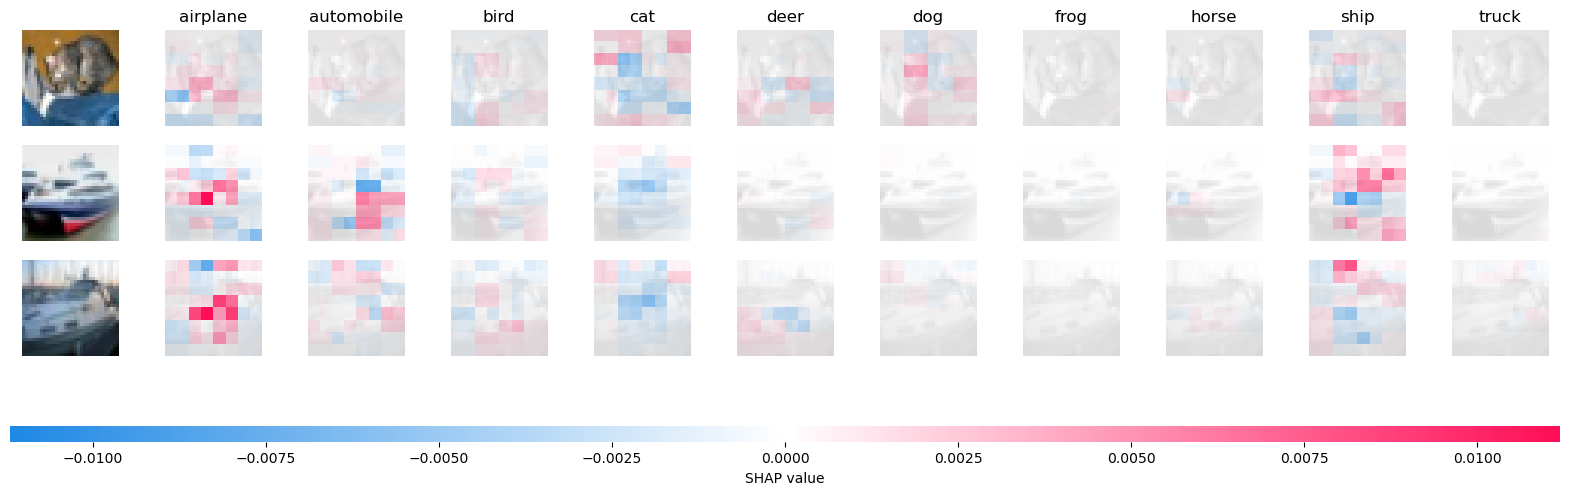

In [40]:
# Explain a few images
test_images, test_labels = get_one_batch(val_loader)
test_images = test_images[:3]
test_np = test_images.permute(0,2,3,1).cpu().numpy()

shap_values = explainer(test_np, max_evals=500, batch_size=50)

# Visualize
shap.image_plot(shap_values, test_np)

##### Sanity Check for SHAP

In [41]:
i = 0
cls = int(predict_proba_numpy(test_np).argmax(axis=1)[i])
print("pixel:", test_np[i].shape)                          # (32,32,3)
print("sv raw:", shap_values.values[i,:,:,:,cls].shape)    # (32,32,3)

pixel: (32, 32, 3)
sv raw: (32, 32, 3)


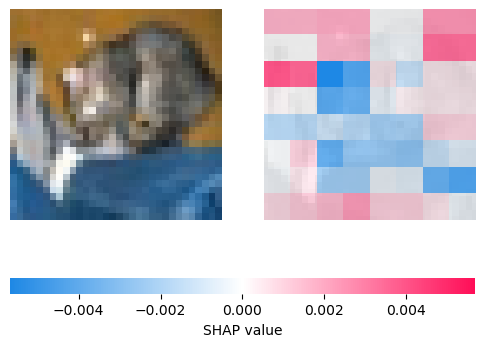

<Figure size 640x480 with 0 Axes>

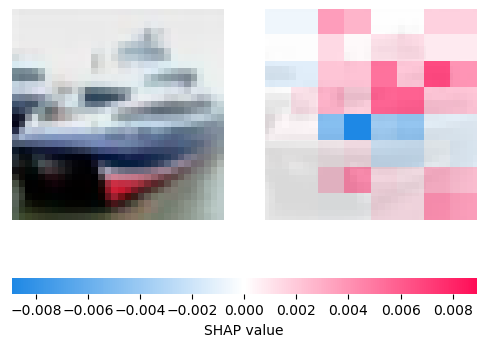

<Figure size 640x480 with 0 Axes>

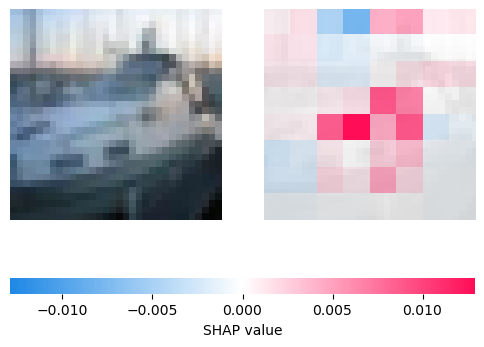

<Figure size 640x480 with 0 Axes>

In [42]:
preds = predict_proba_numpy(test_np).argmax(axis=1)

for i in range(test_np.shape[0]):
    cls = int(preds[i])

    # Extract raw SHAP values for this image and class: (32,32,3)
    sv_img = shap_values.values[i, :, :, :, cls]

    # image_plot expects a list of arrays, one per "output"
    shap.image_plot([sv_img], test_np[i])
    plt.gcf().suptitle(f"SHAP for predicted class: {class_names[cls]}", y=1.02)
    plt.show()

# Limitations of Explainability

While gradient-based saliency, Grad-CAM, and SHAP provide useful insights into model behavior, it is important to critically assess their limitations within the context of this CIFAR-10 experiment.

First, the dataset itself is low-resolution (32×32 pixels). Fine-grained object features are often not clearly distinguishable even to humans. As a result, explanations may appear coarse or noisy, not necessarily because the method fails, but because the underlying visual signal is limited. This restricts how precisely we can localize semantically meaningful regions.

Second, gradient-based methods such as vanilla saliency are known to be sensitive to noise. Small perturbations in the input can significantly alter the gradient signal. These methods often highlight edges or high-frequency textures rather than semantically meaningful object regions. Consequently, saliency maps may reflect local sensitivity rather than true causal importance.

Third, Grad-CAM operates at the resolution of the last convolutional feature map. In this model, the spatial resolution is reduced to 8×8 before upsampling to 32×32. The resulting heatmap is therefore inherently coarse and smoothed via interpolation. This limits spatial precision and may blur object boundaries.

Fourth, SHAP explanations for images rely on perturbation strategies and background baselines. The choice of baseline (e.g., black image, blurred image, dataset mean) directly influences attribution results. Different baselines can produce noticeably different explanations. Additionally, SHAP is computationally expensive and only approximates true Shapley values.

Fifth, explanations are local, not global. Each explanation describes behavior for a specific input and class. These local insights do not necessarily generalize across the dataset. A model may behave differently for visually similar samples.

Finally, explanation methods reveal correlations learned by the model — not necessarily causal reasoning. If the model relies on background artifacts (e.g., sky for airplanes), explanations will faithfully reflect this bias but cannot determine whether the reasoning is logically correct.

In summary, the explanations in this experiment should be interpreted as diagnostic tools rather than definitive evidence of model reasoning.

---

# General Limitations of XAI

Beyond this specific experiment, explainable AI methods face broader conceptual and practical limitations.

## 1. Explanations Are Model-Relative

XAI methods explain the behavior of a specific trained model. If the model changes (different initialization, architecture, or training seed), explanations may change significantly. This limits reproducibility and stability.

## 2. Explanations Are Not Causal

Most XAI methods are based on gradients, perturbations, or feature attribution. These approaches measure sensitivity or association, not causation. A highlighted region may correlate with the prediction without being causally necessary.

## 3. Instability and Sensitivity

Many explanation techniques are sensitive to:

- Small input perturbations
- Random initialization
- Hyperparameter choices
- Choice of baseline (in SHAP)

Two visually similar images can produce very different explanations.

## 4. Method Disagreement

Different explanation methods often produce different attribution maps for the same input. There is no universally accepted ground truth for explanations, making validation difficult.

## 5. Resolution vs Abstraction Trade-Off

Pixel-level explanations (e.g., saliency) provide high resolution but are often noisy. Higher-level methods (e.g., Grad-CAM) provide more semantic localization but sacrifice spatial precision. There is no perfect balance.

## 6. Computational Cost

Perturbation-based methods like SHAP are computationally expensive, especially for image data. This limits scalability to large datasets or real-time applications.

## 7. Human Interpretability Gap

Even when explanations are technically correct, they may not be intuitive or meaningful to human users. Heatmaps require subjective interpretation and can be misinterpreted without domain knowledge.

## 8. Over-Trust Risk

Explanations can increase user confidence in a model, even when the explanations are misleading or unstable. This can create a false sense of security.

## 9. Evaluation Challenge

There is no universal metric for measuring the quality of explanations. Unlike accuracy, the correctness of explanation is difficult to quantify objectively.

### Relevant Criteria

* Contrastive: not just “why x?” but “why x not y?”

* Who is the target audience

* Coherent with beliefs and knowledge

* Generalization: covers many cases

* Truthfulness: explanation is actually true, inthe  real world competes with selectiveness

* Selectiveness: not the entire set of reasons, but the most significant 

## 10. Challenges

* Challenge 1: Evaluation of model interpretability
* Challenge 2: Some methods to explain black box models might be black box themselves	
* Challenge 3: Non-consistent use of terminology (suggestions: Adadi et al., 2018 and Guidotti et al., 2018)
* Challenge 4: Lack of research for interpretable ML for time series
* Challenge 5: Coverage of explanations w.r.t. black box models
* Challenge 6: Integration of domain knowledge into XAI

---

# Final Reflection

Explainability methods are powerful tools for analyzing model behavior, diagnosing errors, and identifying biases. However, they do not provide a complete or definitive understanding of neural network reasoning.

In this tutorial, saliency, Grad-CAM, and SHAP help us inspect model behavior on CIFAR-10. They reveal patterns, biases, and failure modes, but they should be interpreted cautiously.

Explainability enhances transparency, but it does not eliminate uncertainty.


## A good read

https://christophm.github.io/interpretable-ml-book/scope-of-interpretability.html 

https://link.springer.com/chapter/10.1007/978-3-031-04083-2_2

https://towardsdatascience.com/explainable-neural-networks-recent-advancements-part-3-6a838d15f2fb

https://arxiv.org/pdf/1802.07810.pdf